# SNS Sentiment Analysis BERT

Analyze social media texts and measure potential inflammatory / offensive language with a BERT neural network.

(This does not work, unable to pass data through the BERT model, Iter nor Tensor conversions are working at all for the data and model).

In [66]:
import ast
import data_util as du
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import torch
import transformers
from transformers import TFBertModel, BertTokenizer

In [25]:
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased', output_hidden_states=False, return_dict=False)
bert_model.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [26]:
print("Tensorflow Version : ", tf.__version__)
print("Transformers Version : ", transformers.__version__)

Tensorflow Version :  2.14.0
Transformers Version :  4.35.0


# Load the data

In [27]:
# Load dataset
train = pd.read_csv("./datasets/processed/train.csv")
X_train = train[train.columns[0]].apply(ast.literal_eval)[:800]
y_train = train[train.columns[1]].astype(int)[:200]
print(X_train.shape, y_train.shape)

test = pd.read_csv("./datasets/processed/test.csv")
X_test = test[test.columns[0]].apply(ast.literal_eval)[:800]
y_test = test[test.columns[1]].astype(int)[:200]
print(X_test.shape, y_test.shape)

(800,) (200,)
(800,) (200,)


In [28]:
train_text = [" ".join(s) for s in X_train]
test_text = [" ".join(s) for s in X_test]

In [29]:
# Testing
example_input = tokenizer(["Test sentence", "This is a test sentence"], padding='max_length', truncation=True, return_tensors='tf')
example_input

{'input_ids': <tf.Tensor: shape=(2, 512), dtype=int32, numpy=
array([[ 101, 3231, 6251, ...,    0,    0,    0],
       [ 101, 2023, 2003, ...,    0,    0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [34]:
MAX_LENGTH = 128

# Tokenize the training data
X_train_tokens = tokenizer.batch_encode_plus(
    train_text[:200],
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

# Tokenize the testing data
X_test_tokens = tokenizer.batch_encode_plus(
    test_text[:200],
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

# Create and train BERT neural network

In [77]:
def create_bert_model():
    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask')
    token_type_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='token_type_ids')

    bert_output = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    sequence_output = bert_output[0]
    # Take the [CLS] token representation
    pooled_output = sequence_output[:, 0, :]

    x = tf.keras.layers.Dropout(0.2)(pooled_output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [78]:
bert_classifier = create_bert_model()

In [80]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Create a learning rate callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [81]:
BATCH_SIZE = 4

bert_history = bert_classifier.fit(
    [X_train_tokens['input_ids'], X_train_tokens['attention_mask'], X_train_tokens['token_type_ids']],
    y_train,
    epochs=5,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(train_text) // (BATCH_SIZE * 4),
    validation_data=([X_test_tokens['input_ids'], X_test_tokens['attention_mask'], X_test_tokens['token_type_ids']], y_test),
    validation_steps=BATCH_SIZE * 4,
    validation_batch_size=BATCH_SIZE,
    callbacks=lr_callback
)

Epoch 1/5
50/50 [==============================] - 5s 103ms/step - loss: 0.3019 - accuracy: 0.8750 - val_loss: 1.0696 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 2/5
50/50 [==============================] - 5s 95ms/step - loss: 0.2811 - accuracy: 0.9100 - val_loss: 0.8075 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 3/5
50/50 [==============================] - 5s 95ms/step - loss: 0.2491 - accuracy: 0.8900 - val_loss: 0.9969 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 4/5
50/50 [==============================] - 5s 95ms/step - loss: 0.2925 - accuracy: 0.8850 - val_loss: 0.6230 - val_accuracy: 0.6406 - lr: 9.0484e-04
Epoch 5/5
50/50 [==============================] - 5s 97ms/step - loss: 0.1834 - accuracy: 0.9500 - val_loss: 1.0326 - val_accuracy: 0.5781 - lr: 8.1873e-04


In [ ]:
bert_model.save('./models/sns_bert_model')

In [98]:
bert_model.save_weights('./models/sns_bert_weights.h5')

In [ ]:
torch.save(bert_model, './models/sns_bert_model.pth')

In [105]:
bert_preds = bert_classifier.predict([X_test_tokens['input_ids'], X_test_tokens['attention_mask'], X_test_tokens['token_type_ids']])

7/7 [==============================] - 6s 839ms/step


In [107]:
_ = du.get_prfa(y_test, du.probs_to_preds(bert_preds), verbose=True)

Precision: 0.8367346938775511
Recall: 0.35964912280701755
F1 Score: 0.5030674846625767
Accuracy: 0.595


In [104]:
metrics = bert_classifier.evaluate([X_test_tokens['input_ids'], X_test_tokens['attention_mask'], X_test_tokens['token_type_ids']], y_test)
print("Loss:", metrics[0])
print("Accuracy:", metrics[1]) 

7/7 [==============================] - 15s 2s/step - loss: 1.1698 - accuracy: 0.5950
Loss: 1.1697783470153809
Accuracy: 0.5950000286102295


In [108]:
# Use a smaller batch of test data
demo_data = tokenizer(test_text[:5], return_tensors="tf", max_length=128, padding='max_length', truncation=True)

demo_predictions = bert_classifier.predict([demo_data['input_ids'], demo_data['attention_mask'], demo_data['token_type_ids']])

_ = du.get_prfa(y_test[:5], du.probs_to_preds(demo_predictions), verbose=True)

1/1 [==============================] - 5s 5s/step
Precision: 1.0
Recall: 0.5
F1 Score: 0.6666666666666666
Accuracy: 0.8


<Figure size 500x800 with 0 Axes>

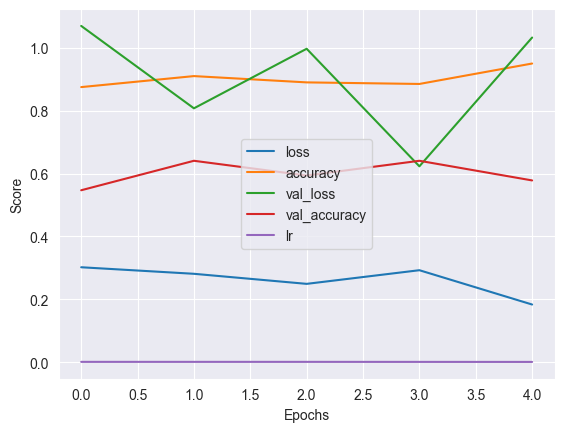

In [109]:
plt.figure(figsize=(5, 8))
pd.DataFrame(bert_history.history).plot()
plt.savefig('./graphs/bert_history.png')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.show()